<a href="https://colab.research.google.com/github/naufalhawari/projects/blob/main/coffee-sales-supply-forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install category_encoders

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ihelon/coffee-sales")
path = kagglehub.dataset_download("ihelon/coffee-sales")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'coffee-sales' dataset.
Using Colab cache for faster access to the 'coffee-sales' dataset.
Path to dataset files: /kaggle/input/coffee-sales


In [ ]:
!ls /kaggle/input/coffee-sales

index_1.csv  index_2.csv


In [ ]:
import pandas as pd

df = pd.read_csv('/kaggle/input/coffee-sales/index_1.csv')

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [ ]:
sales_df = df.groupby(['date', 'coffee_name']).agg({'money': 'sum'}).reset_index().sort_values(by=['coffee_name', 'date']).copy()

In [ ]:
df[df['coffee_name'] == 'Americano']

,date,datetime,cash_type,card,money,coffee_name
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.90,Americano
11,2024-03-02,2024-03-02 10:22:06.957,card,ANON-0000-0000-0010,28.90,Americano
15,2024-03-02,2024-03-02 14:38:35.535,card,ANON-0000-0000-0013,28.90,Americano
17,2024-03-02,2024-03-02 17:34:54.969,card,ANON-0000-0000-0004,28.90,Americano
21,2024-03-03,2024-03-03 12:26:56.098,card,ANON-0000-0000-0012,28.90,Americano
...,...,...,...,...,...,...
3610,2025-03-21,2025-03-21 15:24:42.515,card,ANON-0000-0000-1170,25.96,Americano
3617,2025-03-21,2025-03-21 18:59:24.271,card,ANON-0000-0000-1170,25.96,Americano
3623,2025-03-22,2025-03-22 12:25:59.676,card,ANON-0000-0000-1306,25.96,Americano
3624,2025-03-22,2025-03-22 13:06:21.590,card,ANON-0000-0000-1309,25.96,Americano


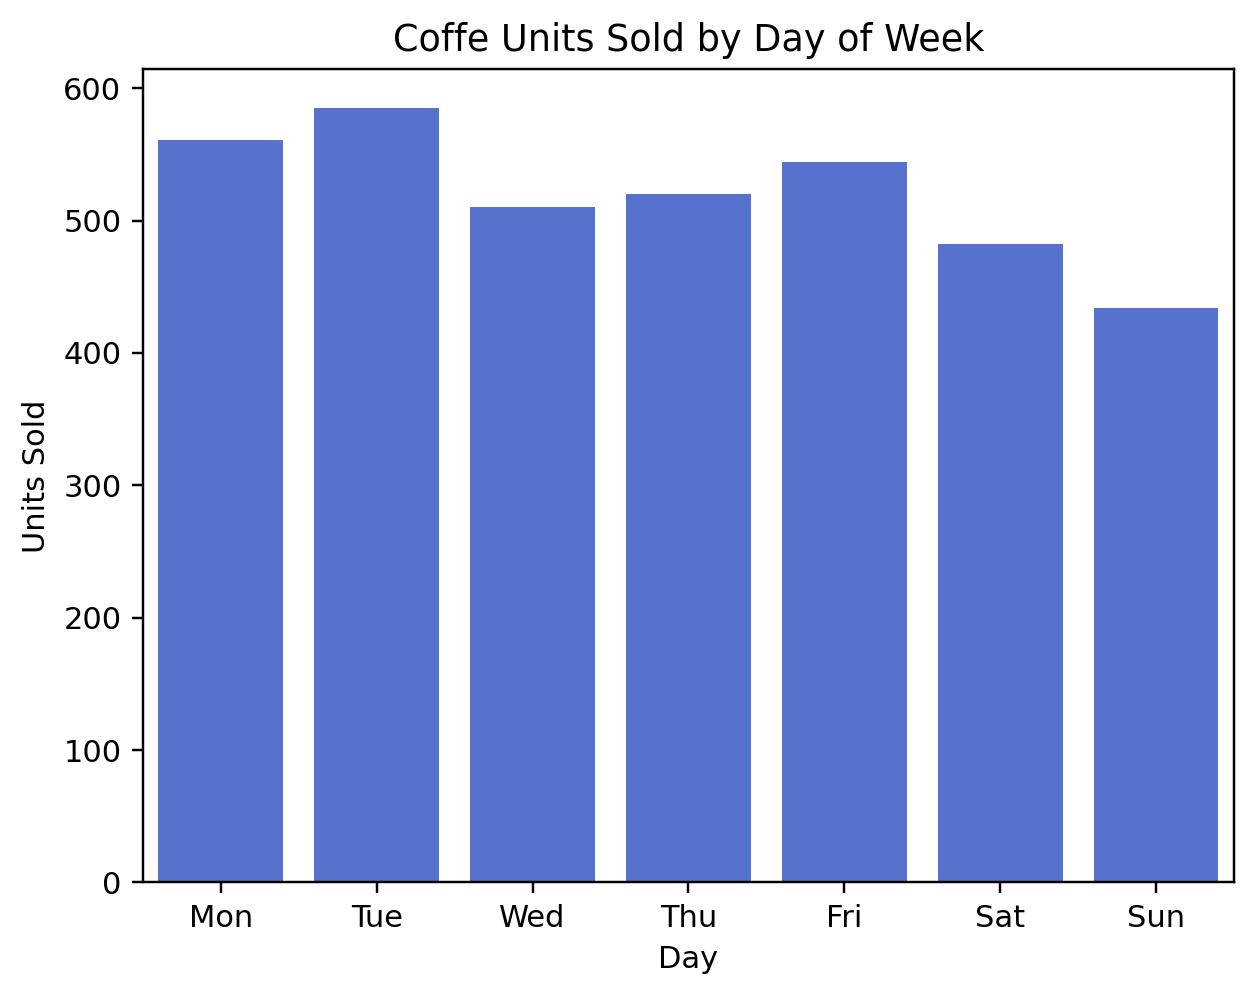

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(dpi=220)
sns.countplot(df, x=df.datetime.dt.day_of_week, orient='v', color='royalblue')

plt.xlabel('Day')
plt.ylabel('Units Sold')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Coffe Units Sold by Day of Week');

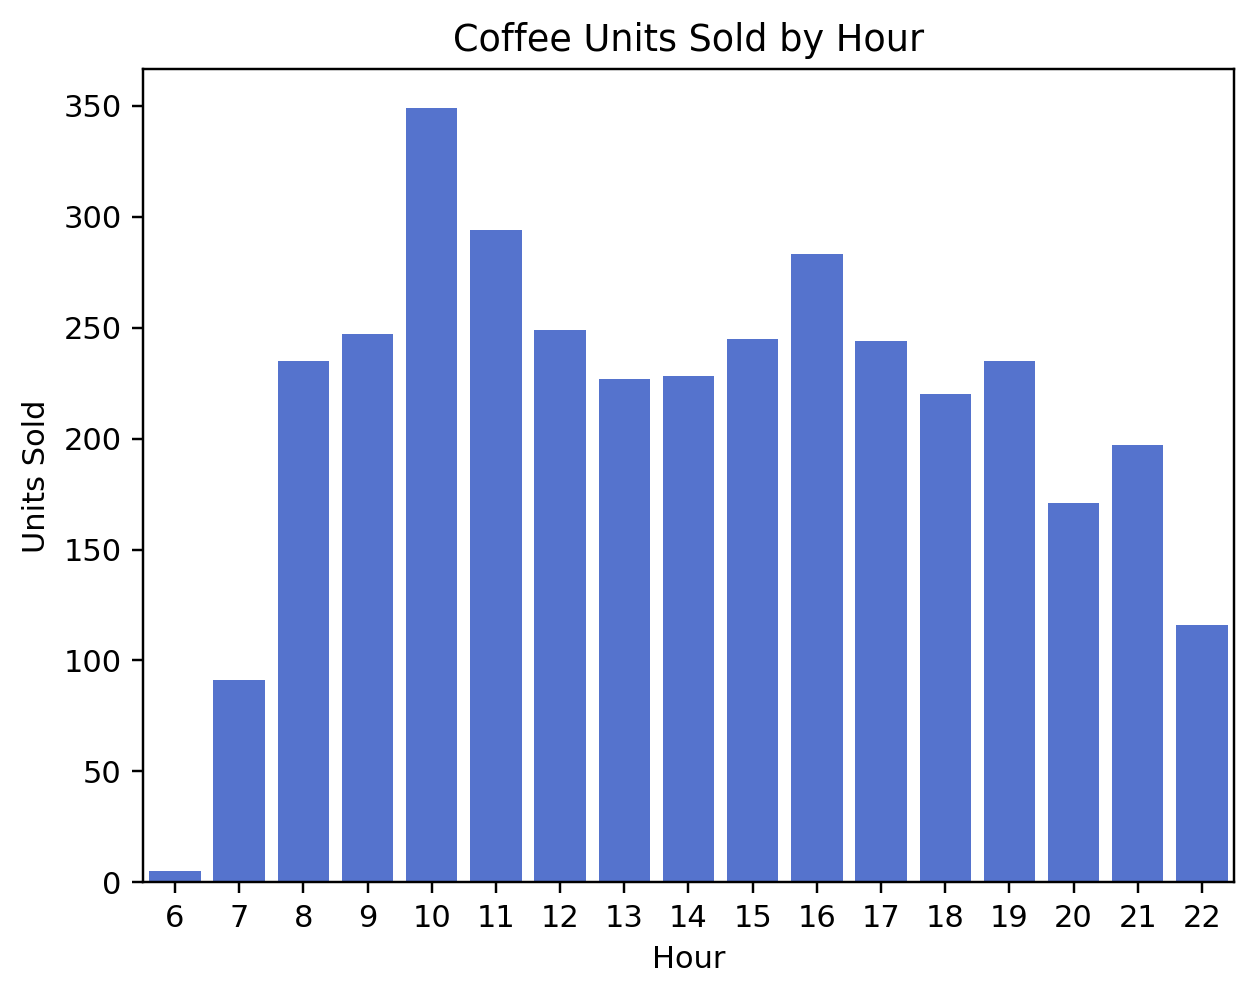

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(dpi=220)
sns.countplot(df, x=df.datetime.dt.hour, orient='v', color='royalblue')

plt.xlabel('Hour')
plt.ylabel('Units Sold')
plt.title('Coffee Units Sold by Hour');

In [ ]:
sales_df = df.groupby(['date', 'coffee_name']).agg(revenue=('money', 'sum'),
                                        units_sold=('money', 'count')).reset_index().sort_values(by=['coffee_name', 'date']).copy()

In [ ]:
sales_df.head()

,date,coffee_name,revenue,units_sold
0,2024-03-01,Americano,28.9,1
5,2024-03-02,Americano,86.7,3
8,2024-03-03,Americano,28.9,1
21,2024-03-06,Americano,28.9,1
25,2024-03-07,Americano,28.9,1


In [ ]:
revenue_df = sales_df.groupby('date').agg(revenue=('revenue', 'sum')).copy()

revenue_df

,revenue
date,
2024-03-01,396.30
2024-03-02,228.10
2024-03-03,349.10
2024-03-04,135.20
2024-03-05,338.50
...,...
2025-03-19,623.56
2025-03-20,597.60
2025-03-21,636.80


In [ ]:
revenue_df = revenue_df.reset_index()

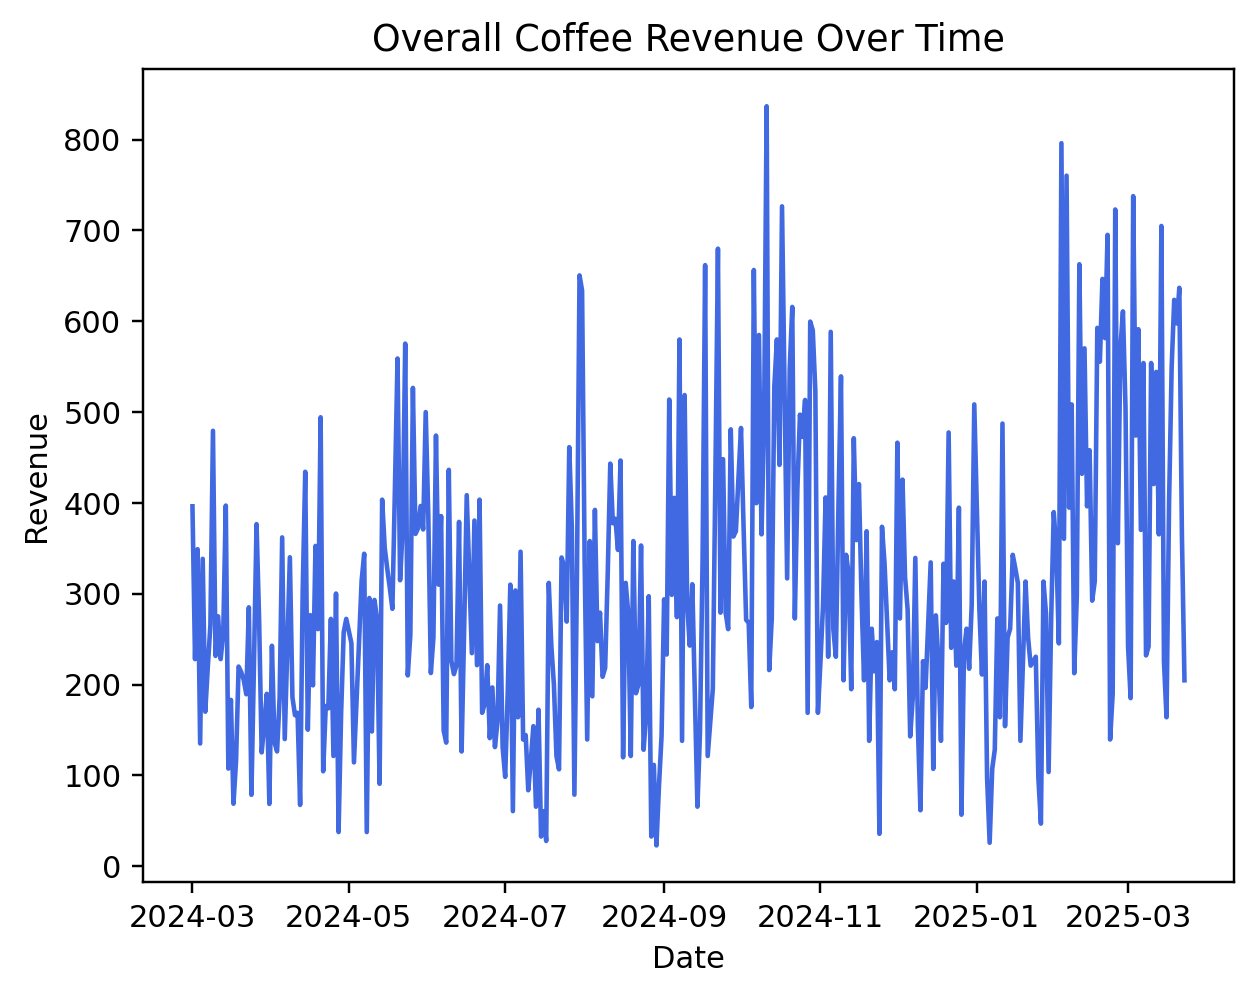

In [ ]:
plt.figure(dpi=220)

sns.lineplot(data=revenue_df, x='date', y='revenue', color='royalblue')

plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Overall Coffee Revenue Over Time');

<Figure size 1408x1056 with 0 Axes>

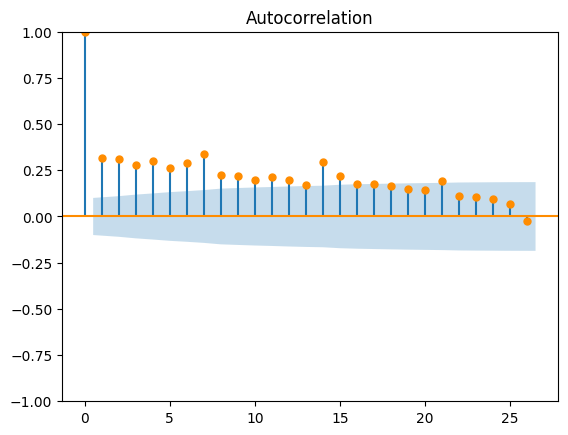

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(dpi=220);
plot_acf(revenue_df['revenue'], color='darkorange');

In [ ]:
from statsmodels.tsa.stattools import adfuller

print('Unit root existence p-value:', adfuller(revenue_df['revenue'])[1])

Unit root existence p-value: 0.022257540844443976


<Axes: ylabel='seasonal'>

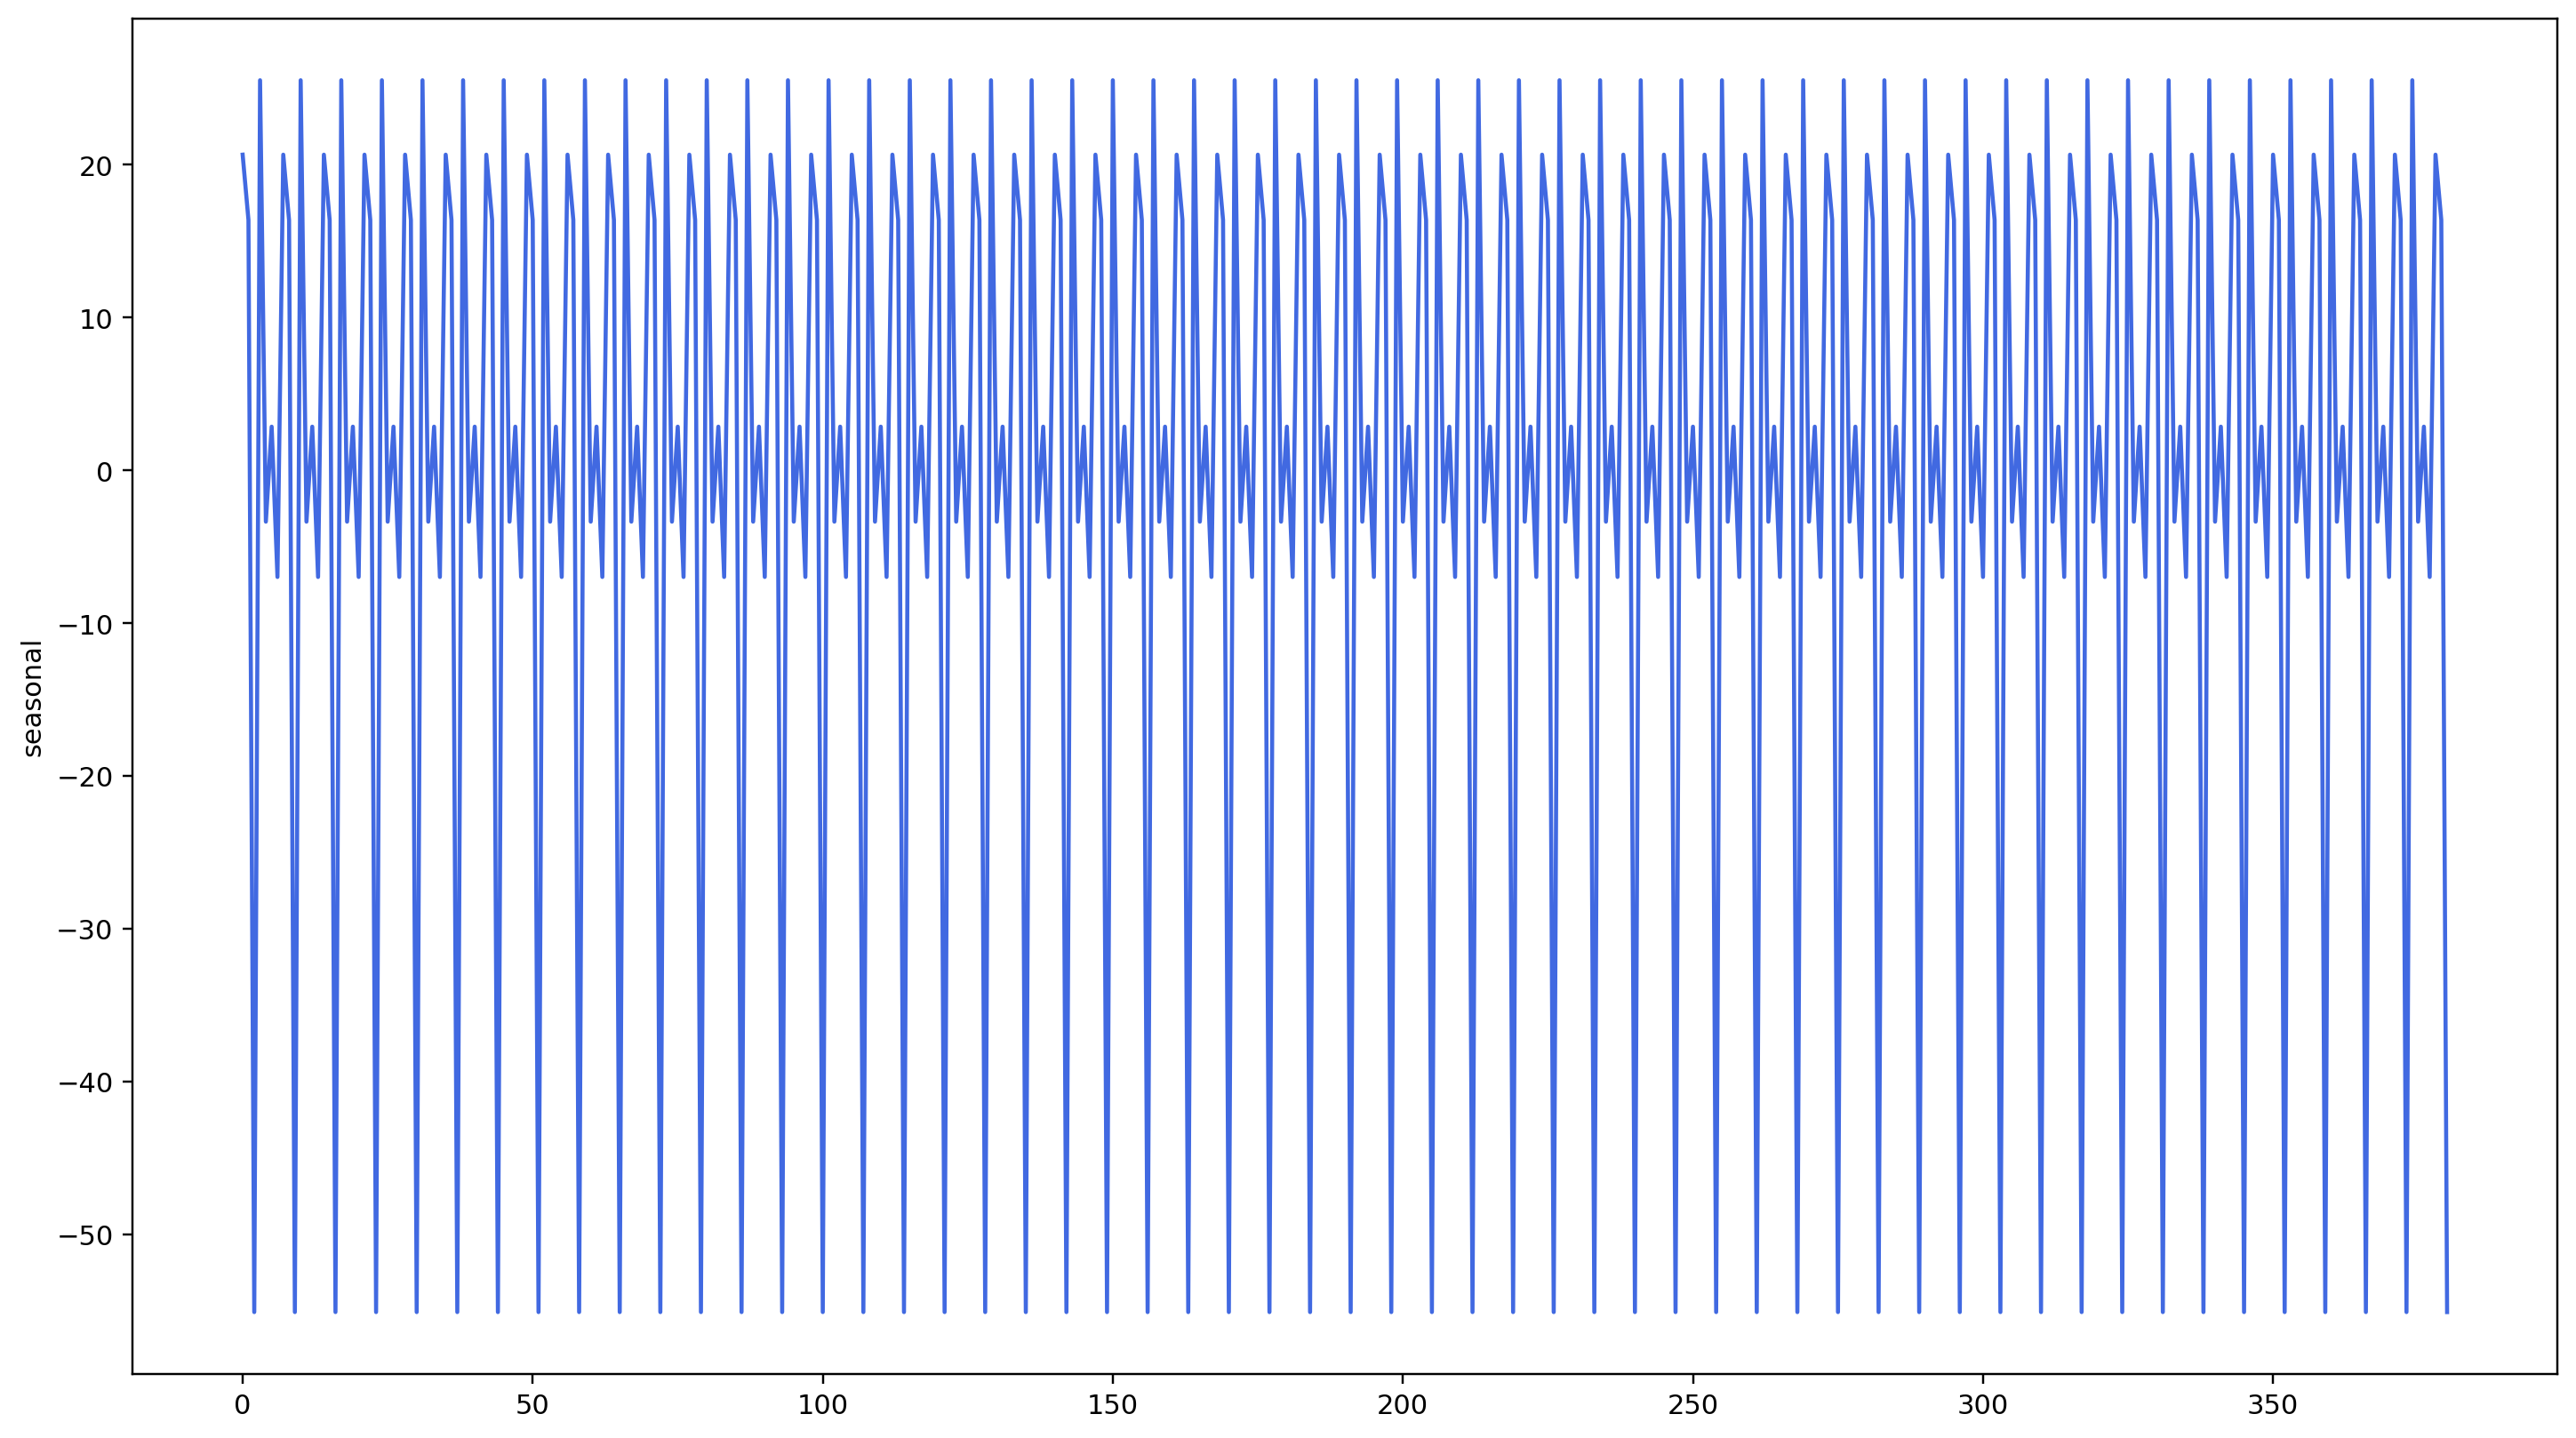

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(dpi=220, figsize=(16,9))
sns.lineplot(x=range(381), y=seasonal_decompose(revenue_df['revenue'], period=7).seasonal, color='royalblue')

In [ ]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.7/145.7 kB 9.7 MB/s eta 0:00:00


In [ ]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series

fh = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("2025-03-24", periods=365, freq="D")), is_relative=False
)

In [ ]:
fh

ForecastingHorizon(['2025-03-24', '2025-03-25', '2025-03-26', '2025-03-27',
             '2025-03-28', '2025-03-29', '2025-03-30', '2025-03-31',
             '2025-04-01', '2025-04-02',
             ...
             '2026-03-14', '2026-03-15', '2026-03-16', '2026-03-17',
             '2026-03-18', '2026-03-19', '2026-03-20', '2026-03-21',
             '2026-03-22', '2026-03-23'],
            dtype='period[D]', length=365, is_relative=False)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='revenue'>)

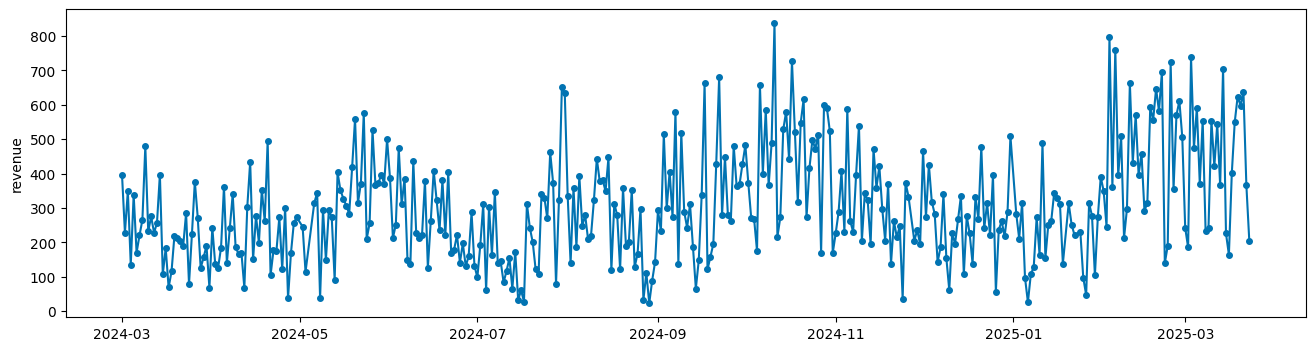

In [ ]:
plot_series(revenue_df.set_index('date'))

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 60.1 MB/s eta 0:00:00


In [ ]:
from sktime.forecasting.timemoe import TimeMoEForecaster
from sktime.forecasting.time_llm import TimeLLMForecaster
from sktime.forecasting.arima import AutoARIMA, ARIMA

forecaster = TimeLLMForecaster(
    pred_len=30,
    seq_len=64,
    llm_model='GPT2'
)

from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, RobustScaler

pipe_y = TransformedTargetForecaster(
    steps=[
        ("detrend", Detrender()),
        ("scaler", RobustScaler()),
        ("forecaster", forecaster),
    ]
)

In [ ]:
from sktime.split import ExpandingGreedySplitter

cv = ExpandingGreedySplitter(
    test_size=30,
    step_length=15
)

In [ ]:
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.forecasting.model_evaluation import evaluate

results = evaluate(
    forecaster=pipe_y,
    y=revenue_df['revenue'],
    X=None,
    cv=cv,
    scoring=[MeanSquaredError(square_root=True),],
    return_model=False,
    return_data=False
)

In [ ]:
results

,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff
0,200.975737,0.048075,0.073508,291,290
1,217.568505,0.041578,0.072062,306,305
2,232.209254,0.040758,0.064306,321,320
3,285.568083,0.039985,0.063345,336,335
4,253.458021,0.045520,0.052933,351,350


# Nixtla

In [ ]:
!pip install mlforecast neuralforecast statsforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.8/344.8 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.6/766.6 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install --upgrade torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2/287.2 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32

## Statsforecast

In [ ]:
from statsforecast.models import AutoETS, AutoARIMA
from statsforecast import StatsForecast # required to instantiate StastForecast object and use cross-validation method

In [ ]:
models = [AutoETS(season_length = 24), AutoARIMA()]

sf = StatsForecast(
    models = models,
    freq = 'D',
    n_jobs = 2
)

In [ ]:
cv_df = sf.cross_validation(
    df = df,
    h = 24,
    step_size = 24,
    n_windows = 3
  )

In [ ]:
from utilsforecast.losses import rmse

cv_rmse = evaluate(
    cv_df.drop(columns='cutoff'),
    metrics=[rmse],
    agg_fn='mean',
)

print(f"RMSE using cross-validation: {cv_rmse['AutoETS'].item():.1f}")

RMSE using cross-validation: 32.7


In [ ]:
cv_rmse = evaluate(
    cv_df.drop(columns='cutoff'),
    metrics=[rmse],
    agg_fn='mean',
)

print(f"RMSE using cross-validation: {cv_rmse['AutoARIMA'].item():.1f}")

RMSE using cross-validation: 63.4


## MLForecast

In [ ]:
from utilsforecast.plotting import plot_series
from mlforecast import MLForecast


In [ ]:
import lightgbm as lgb
from mlforecast.target_transforms import Differences

models = [lgb.LGBMRegressor(verbosity=-1)]

mlf = MLForecast(
    models=models,
    freq=1,# our series have integer timestamps, so we'll just add 1 in every timeste,
    target_transforms=[Differences([1])],
    lags=range(1, 25)
)

In [ ]:
import numpy as np

Y_df = revenue_df.rename(columns={'date': 'ds', 'revenue': 'y'}).copy()
Y_df['unique_id'] = 'Americano'
Y_df['ds'] = np.arange(len(Y_df))

In [ ]:
Y_df

,ds,y,unique_id
0,0,396.30,Americano
1,1,228.10,Americano
2,2,349.10,Americano
3,3,135.20,Americano
4,4,338.50,Americano
...,...,...,...
376,376,623.56,Americano
377,377,597.60,Americano
378,378,636.80,Americano
379,379,365.42,Americano


In [ ]:
cv_df = mlf.cross_validation(
    df=Y_df,
    h=24,
    n_windows=3,
)

In [ ]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse

cv_rmse = evaluate(
    cv_df.drop(columns='cutoff'),
    metrics=[rmse],
    agg_fn='mean',
)

print(f"RMSE using cross-validation: {cv_rmse['LGBMRegressor'].item():.1f}")

RMSE using cross-validation: 338.9


## NeuralForecast

In [ ]:
import logging
import matplotlib.pyplot as plt
import pandas as pd
from utilsforecast.plotting import plot_series

from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS, NBEATS

import numpy as np

In [ ]:
Y_df = revenue_df.rename(columns={'date': 'ds', 'revenue': 'y'}).copy()
Y_df['unique_id'] = 'Americano'
Y_df['ds'] = np.arange(len(Y_df))

In [ ]:
h = 30
nf = NeuralForecast(models=[
    NHITS(h=h, input_size=2*h, max_steps=500, enable_progress_bar=False, logger=False),
    ], freq=1);
cv_df = nf.cross_validation(Y_df, n_windows=4, step_size=h, verbose=0)
cv_df.head()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.184    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode
INFO:pytorch_light

,unique_id,ds,cutoff,NHITS,y
0,Americano,261,260,338.330872,138.14
1,Americano,262,260,291.502686,261.58
2,Americano,263,260,303.720337,214.56
3,Americano,264,260,415.221313,246.88
4,Americano,265,260,383.855713,35.76
